# Overcomplete Tomography

In [2]:
from octo.octo import OvercompleteBasis
from octo.basis import PixelBasis2D, CosineBasis2D
from octo.measurement import PathIntegral

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [4]:
rng = np.random.default_rng(42)

In [3]:
Nx = 20
Ny = 20
cosine = CosineBasis2D(Nx, Ny)
pixel = PixelBasis2D(Nx, Ny)

## Synthetic Data

Start by creating a ground truth image, combining global and local features

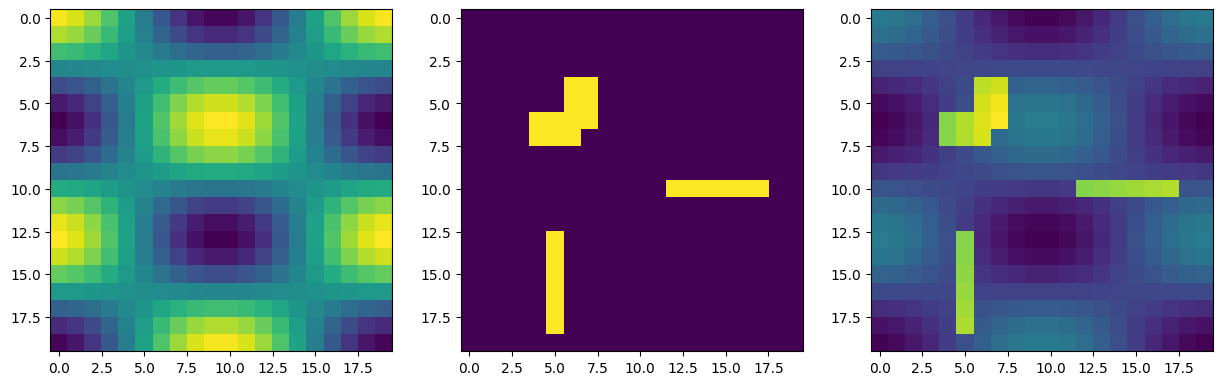

In [26]:
true_cosine_coefficients = np.zeros((Nx * Ny))
# true_cosine_coefficients[rng.integers(0, Nx * Ny, 10)] = rng.uniform(-1, 1, 10)
true_cosine_coefficients[3 * Ny + 2] = 1
true_cosine_image = cosine(true_cosine_coefficients)

true_pixel_coefficients = np.zeros((Nx, Ny))
true_pixel_coefficients[4:7, 6:8] = 0.3
true_pixel_coefficients[6:8, 4:7] = 0.3
true_pixel_coefficients[10, 12:18] = 0.3
true_pixel_coefficients[13:19, 5] = 0.3
true_pixel_coefficients = true_pixel_coefficients.flatten()
true_pixle_image = pixel(true_pixel_coefficients)

true_image = true_pixle_image + true_cosine_image

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(true_cosine_image.reshape(Nx, Ny))
axs[1].imshow(true_pixle_image.reshape(Nx, Ny))
axs[2].imshow(true_image.reshape(Nx, Ny))

Create a synthetic noiseless dataset.  The forward model here is simple path integration for paths that travel all the way across the image

$$d_i = \int_{\Gamma_i} f(x,y) \mathrm{d}s_i$$

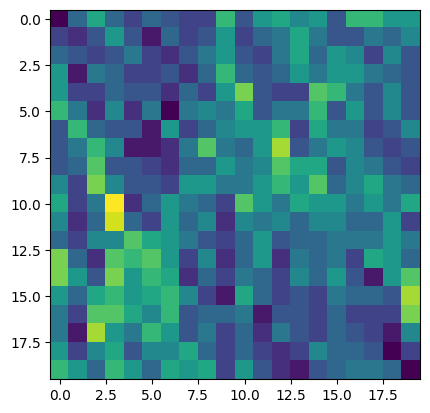

In [41]:
npaths=200
measurement = PathIntegral(Nx, Ny, npaths=npaths)

pm = np.sum(measurement.path_matrix.reshape((npaths, Nx, Ny)), axis=0)
plt.imshow(pm)

In [42]:
synthetic = measurement(true_image)

## Overcomplete Basis

Create an overcomplete basis, weighting the two bases and overall regularisation evenly

In [44]:
cosine.compute_jacobian(measurement)
pixel.compute_jacobian(measurement)
overcomplete = OvercompleteBasis(synthetic, [cosine, pixel])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 160000 is different from 400)